# Model Training and Evaluation

___
## Configurações e Dataprep

In [1]:
## bibliotecas
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import *
from scipy.stats import * 

from utils.eda import *
from utils.modelling_tools import *

%load_ext autoreload
%autoreload 2

In [2]:
## configurações

np.set_printoptions()
np.set_printoptions(precision=4, suppress=True)

pd.options.display.float_format = '{:.4f}'.format

%matplotlib inline
from matplotlib import rcParams

plt_params = {
    'figure.figsize':(6,4),
    'figure.dpi':75,
    'font.size':16,
    'font.family':'serif',
    'xtick.labelsize':14,
    'ytick.labelsize':14,
    'axes.labelsize':14,
    'legend.fontsize':10,
    'lines.linewidth':12,
    'grid.color':'gray',
    'savefig.bbox':'tight',
    'savefig.dpi':1000,
    'savefig.transparent':False,
}

rcParams.update(plt_params)

import warnings
warnings.filterwarnings('ignore')

seed = 123

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
## Carregando dataset
df_raw = pd.read_csv('data.csv', sep=';')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
## Definição da variável-resposta
actual_target = 'y'
df_raw[actual_target].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

In [5]:
## mapeando a variável-resposta para numeric
target_map = {'no':0, 'yes':1}
df_raw['response'] = df_raw[actual_target].map(target_map)

#### IV e WoE

In [6]:
#### IV 
iv, woe = iv_woe(data=df_raw.drop('y', axis=1),
                         target='response',
                         bins=10, show_woe=False)

iv['Predictive Power'] = iv['IV'].map(predictive_power)

Information value of age is 0.139397
Information value of job is 0.188713
Information value of marital is 0.028215
Information value of education is 0.048576
Information value of default is 0.127776
Information value of housing is 0.001383
Information value of loan is 0.000269
Information value of contact is 0.251663
Information value of month is 0.485117
Information value of day_of_week is 0.006493
Information value of duration is 1.961794
Information value of campaign is 0.054246
Information value of pdays is 0.0
Information value of previous is 0.3505
Information value of poutcome is 0.547671
Information value of emp.var.rate is 1.06975
Information value of cons.price.idx is 0.440236
Information value of cons.conf.idx is 0.86074
Information value of euribor3m is 1.046047
Information value of nr.employed is 1.173723


### BASE SEM MANIPULAÇÃO

In [7]:
numerics = ['int16','int32','int64','float16','float32','float64']
numeric_features = df_raw.select_dtypes(include=numerics).columns
df_raw = df_raw[numeric_features]

## Separando bases de Treino e Teste
y = df_raw['response']
X = df_raw.drop('response', axis=1)


In [8]:
feature_names = X.columns
feature_names

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [9]:

from sklearn.model_selection import train_test_split

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)

## dataset para estudo
df = pd.concat([X_train, pd.DataFrame(y_train, columns=['response'])], axis=1).reset_index(drop=True)

## dataset para teste OOS
df = pd.concat([X_test, pd.DataFrame(y_test, columns=['response'])], axis=1).reset_index(drop=True)

In [10]:
## Proporção das Classes
p_class0 = np.sum(y_train==0)/y_train.shape[0]
p_class1 = np.sum(y_train==1)/y_train.shape[0]

print(f'Proporção da Classe 0: {p_class0:.2%}')
print(f'Proporção da Classe 1: {p_class1:.2%}')

Proporção da Classe 0: 88.73%
Proporção da Classe 1: 11.27%


___
## Data Undersample (RUS)

Melhorando a classificação criando bases com o mesmo numero de entradas para cada classe.  

obs. a Amostra Aleatório Simples em uma unica exceção. o correto é escolher ao menos 5 AAS distintas (sem reposição) e avaliar se todas levam ao mesmo resultado de KS.  
Outra alternativa é que a distribuição da amostra seja representativa quando comparada a população

In [11]:
## Proporção de classe 0 para classe 1.
## Se 1, num_0 = num_1. Se 2, num_0 = 2*num_1
class1_prop = 1 ## inteiro

## Contando o numero da classe com menos observações, para fazer a extração do excedente
sample_size = y_train[y_train==0].shape[0] - class1_prop * np.sum(y_train==1)
class0_idx = np.where(y_train==0)[0]
class1_idx = np.where(y_train==1)[0]

## AAS dos indices da classe 0 ser removido
class0_random_indices = np.random.choice(class0_idx, sample_size, replace=False)

In [12]:
## Base de Dados com RUS (removendo os indices sorteados)
X_train_RUS = np.delete(X_train, class0_random_indices, axis=0) 
y_train_RUS = np.delete(y_train, class0_random_indices, axis=0)

In [13]:
## Proporção das Classes
p_class0_RUS = np.sum(y_train_RUS==0)/y_train_RUS.shape[0]
p_class1_RUS = np.sum(y_train_RUS==1)/y_train_RUS.shape[0]

print(f'Proporção da Classe 0: {p_class0_RUS:.2%}')
print(f'Proporção da Classe 1: {p_class1_RUS:.2%}')

Proporção da Classe 0: 50.00%
Proporção da Classe 1: 50.00%


___
## Baseline Model - Naive Bayes

Para a Construção do modelo de baseline, o modelo é treinado com a amostra original (1:10) 

In [14]:
modelo = 'nb_baseline'

#### Model Training

In [15]:
from sklearn.naive_bayes import GaussianNB

nbModel= GaussianNB()

nbModel.fit(X_train, y_train)


GaussianNB()

In [16]:
dict_str = str(nbModel.get_params(deep=True))

print(dict_str)

{'priors': None, 'var_smoothing': 1e-09}


#### Feature Evaluation

In [17]:
from sklearn.inspection import permutation_importance

r = permutation_importance(nbModel, X_test, y_test, n_repeats=30,
                           scoring='roc_auc', random_state=seed)

In [18]:
features_names_lst = []
importance_mean_lst = []
importance_std_lst = []

for i in r.importances_mean.argsort()[::-1]: ## ordena do mais importante para o menor
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0: ## seleciona features com IC = 0.95
        features_names_lst.append(feature_names[i])        
        importance_mean_lst.append(np.round(r.importances_mean[i], decimals=5))        
        importance_std_lst.append(np.round(r.importances_std[i], decimals=5))    


df_features = pd.DataFrame({
    'feature': features_names_lst,
    'mean': importance_mean_lst,
    'std': importance_std_lst,
})

In [19]:
df_feature_importance = pd.merge(df_features, iv, how='inner',
                                 left_on='feature', right_on='Variable').drop('Variable', axis=1)

df_feature_importance.head(10)

,feature,mean,std,IV,Predictive Power
0,duration,0.1094,0.0024,1.9618,suspicious
1,pdays,0.0274,0.0021,0.0000,useless
2,campaign,0.0098,0.0041,0.0542,weak
3,nr.employed,0.0095,0.0015,1.1737,suspicious
4,emp.var.rate,0.0041,0.0013,1.0698,suspicious
5,previous,0.0038,0.0015,0.3505,strong
6,age,0.0031,0.0006,0.1394,medium
7,cons.conf.idx,0.0010,0.0004,0.8607,suspicious


### Model Evaluation

In [20]:
nb_yhat, nb_yprob, nb_rocauc, nb_aucpr = model_eval(nbModel, X_test, y_test)

Accuracia: 87.14%
AUC-ROC Score médio: 0.8708
AUC-PR Score médio: 0.4934


#### Curva ROC

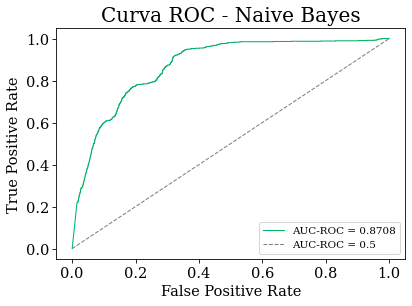

In [21]:
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_test, nb_yprob[:,1])
figura = plot_curva_roc(nb_fpr, nb_tpr, nb_rocauc, 'Naive Bayes')

#### Curva Precision-Recall

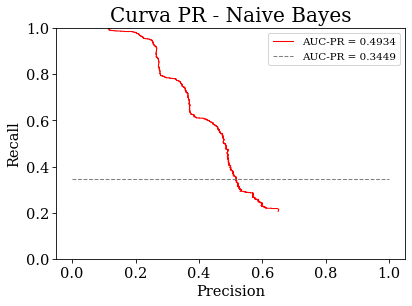

In [22]:
nb_precision, nb_recall, nb_thresholds_pr = precision_recall_curve(y_test, nb_yprob[:,1])
figura = plot_curva_pr(nb_precision, nb_recall, nb_aucpr, 'Naive Bayes')

#### Komogorov-Smirnov

In [23]:
df_clf_baseline = pd.DataFrame({'target': y_test, 'nb_yprob':nb_yprob[:,1]})


nb_stat_ks, nb_ks_val = ks(df_clf_baseline)

KS: 0.5959
p-valor: 0.0000


#### Separação de Classes

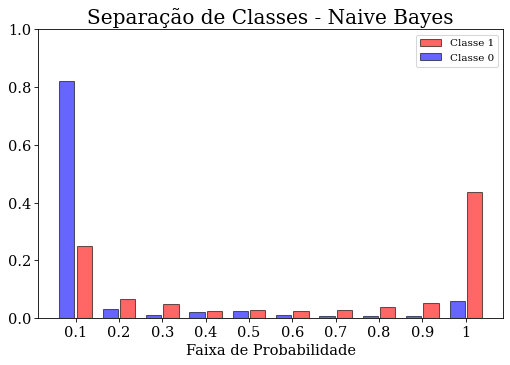

In [24]:
figura, classe0, classe1 = plot_separacao_classes(dataset=df_clf_baseline,
                                                 colunas=['nb_yprob'],
                                                 titulos=['Naive Bayes'],
                                                 modelo=modelo)

In [25]:
df_metrics = pracc_metrics(y_test, nb_yprob)

df_metrics['Class 0'] = classe0[0]
df_metrics['Class 1'] = classe1[0]
df_metrics['Class 0 Ratio'] = np.round( df_metrics['Class 0'] / (df_metrics['Class 1'] + df_metrics['Class 0']), 4)
df_metrics['Class 1 Ratio'] = np.round( df_metrics['Class 1'] / (df_metrics['Class 1'] + df_metrics['Class 0']), 4)

df_metrics

,percentil,tp,tn,fp,fn,precision,recall,accuracy,Class 0,Class 1,Class 0 Ratio,Class 1 Ratio
0,0.1000,695,6000,1310,233,0.6546,0.7849,0.8127,0.8208,0.2511,0.7658,0.2342
1,0.2000,634,6230,1080,294,0.6624,0.7677,0.8332,0.0315,0.0657,0.3237,0.6763
2,0.3000,590,6307,1003,338,0.6598,0.7493,0.8372,0.0105,0.0474,0.1818,0.8182
3,0.4000,566,6464,846,362,0.6739,0.7471,0.8534,0.0215,0.0259,0.4537,0.5463
4,0.5000,540,6639,671,388,0.6953,0.7451,0.8714,0.0239,0.0280,0.4608,0.5392
5,0.6000,516,6711,599,412,0.7025,0.7370,0.8773,0.0098,0.0259,0.2758,0.7242
6,0.7000,489,6770,540,439,0.7072,0.7265,0.8812,0.0081,0.0291,0.2172,0.7828
7,0.8000,455,6828,482,473,0.7104,0.7122,0.8841,0.0079,0.0366,0.1780,0.8220
8,0.9000,406,6887,423,522,0.7096,0.6898,0.8853,0.0081,0.0528,0.1326,0.8674
9,1.0000,191,7207,103,737,0.7784,0.5959,0.8980,0.0579,0.4375,0.1168,0.8832


#### Learning Curve

roc_auc: Score
Train Score: 0.869 (0.002)Test Score: 0.869 (0.001)
--------------------


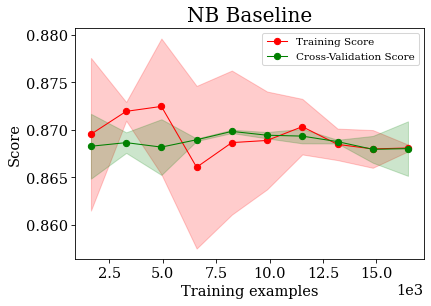

In [26]:
figura, score_txt, nb_train_stat, nb_val_stat = plot_learning_curve(
    nbModel, X_train, y_train, title='NB Baseline', cv=2, scorer='roc_auc'
)

#### Teste de Significância

Verificar se a metrica AUC do teste é uma estatística com probabilidade de vir do modelo treinado

In [27]:
nb_val_stat

[0.868529424317315, 0.0013867042540246038, 2]

In [28]:
p_val = t_test_S(
    x0 = nb_rocauc,
    x_hat = nb_val_stat[0],
    S = nb_val_stat[1],
    n = nb_val_stat[2]
)

Probabilidade da metrica calculada para base de teste pertencer à validação de treino:
P-Valor = 0.1297 (-2.317)
O valor 0.8708 tem probabilidade de 12.97% de pertencer a validação por flutuação estatística, e com IC=0.5, rejeito H0


Para a Construção do modelo de baseline, o modelo é treinado com a amostra original (1:10) 

In [29]:
modelo = 'nb_baseline'

#### Model Training

In [30]:
from sklearn.naive_bayes import GaussianNB

nbModel= GaussianNB()

nbModel.fit(X_train, y_train)


GaussianNB()

In [31]:
dict_str = str(nbModel.get_params(deep=True))

print(dict_str)

{'priors': None, 'var_smoothing': 1e-09}


#### Feature Evaluation

In [32]:
from sklearn.inspection import permutation_importance

r = permutation_importance(nbModel, X_test, y_test, n_repeats=30,
                           scoring='roc_auc', random_state=seed)

In [33]:
features_names_lst = []
importance_mean_lst = []
importance_std_lst = []

for i in r.importances_mean.argsort()[::-1]: ## ordena do mais importante para o menor
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0: ## seleciona features com IC = 0.95
        features_names_lst.append(feature_names[i])        
        importance_mean_lst.append(np.round(r.importances_mean[i], decimals=5))        
        importance_std_lst.append(np.round(r.importances_std[i], decimals=5))    


df_features = pd.DataFrame({
    'feature': features_names_lst,
    'mean': importance_mean_lst,
    'std': importance_std_lst,
})

In [34]:
df_feature_importance = pd.merge(df_features, iv, how='inner',
                                 left_on='feature', right_on='Variable').drop('Variable', axis=1)

df_feature_importance.head(10)

,feature,mean,std,IV,Predictive Power
0,duration,0.1094,0.0024,1.9618,suspicious
1,pdays,0.0274,0.0021,0.0000,useless
2,campaign,0.0098,0.0041,0.0542,weak
3,nr.employed,0.0095,0.0015,1.1737,suspicious
4,emp.var.rate,0.0041,0.0013,1.0698,suspicious
5,previous,0.0038,0.0015,0.3505,strong
6,age,0.0031,0.0006,0.1394,medium
7,cons.conf.idx,0.0010,0.0004,0.8607,suspicious


### Model Evaluation

In [35]:
nb_yhat, nb_yprob, nb_rocauc, nb_aucpr = model_eval(nbModel, X_test, y_test)

Accuracia: 87.14%
AUC-ROC Score médio: 0.8708
AUC-PR Score médio: 0.4934


#### Curva ROC

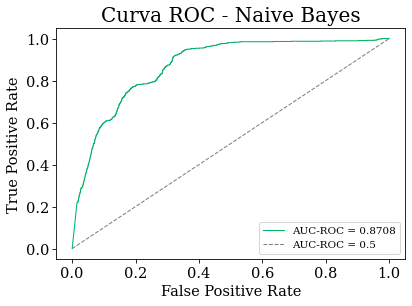

In [36]:
nb_fpr, nb_tpr, nb_thresholds = roc_curve(y_test, nb_yprob[:,1])
figura = plot_curva_roc(nb_fpr, nb_tpr, nb_rocauc, 'Naive Bayes')

#### Curva Precision-Recall

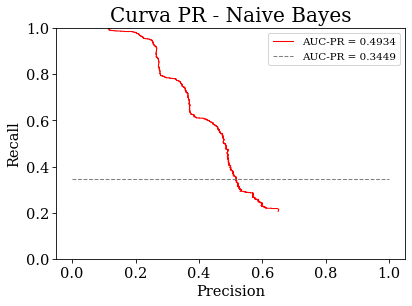

In [37]:
nb_precision, nb_recall, nb_thresholds_pr = precision_recall_curve(y_test, nb_yprob[:,1])
figura = plot_curva_pr(nb_precision, nb_recall, nb_aucpr, 'Naive Bayes')

#### Komogorov-Smirnov

In [38]:
df_clf_baseline = pd.DataFrame({'target': y_test, 'nb_yprob':nb_yprob[:,1]})


nb_stat_ks, nb_ks_val = ks(df_clf_baseline)

KS: 0.5959
p-valor: 0.0000


#### Separação de Classes

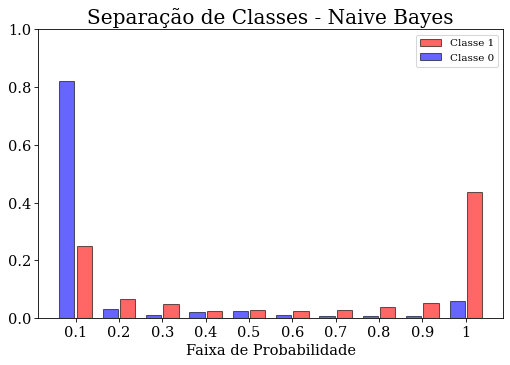

In [39]:
figura, classe0, classe1 = plot_separacao_classes(dataset=df_clf_baseline,
                                                 colunas=['nb_yprob'],
                                                 titulos=['Naive Bayes'],
                                                 modelo=modelo)

In [40]:
df_metrics = pracc_metrics(y_test, nb_yprob)

df_metrics['Class 0'] = classe0[0]
df_metrics['Class 1'] = classe1[0]
df_metrics['Class 0 Ratio'] = np.round( df_metrics['Class 0'] / (df_metrics['Class 1'] + df_metrics['Class 0']), 4)
df_metrics['Class 1 Ratio'] = np.round( df_metrics['Class 1'] / (df_metrics['Class 1'] + df_metrics['Class 0']), 4)

df_metrics

,percentil,tp,tn,fp,fn,precision,recall,accuracy,Class 0,Class 1,Class 0 Ratio,Class 1 Ratio
0,0.1000,695,6000,1310,233,0.6546,0.7849,0.8127,0.8208,0.2511,0.7658,0.2342
1,0.2000,634,6230,1080,294,0.6624,0.7677,0.8332,0.0315,0.0657,0.3237,0.6763
2,0.3000,590,6307,1003,338,0.6598,0.7493,0.8372,0.0105,0.0474,0.1818,0.8182
3,0.4000,566,6464,846,362,0.6739,0.7471,0.8534,0.0215,0.0259,0.4537,0.5463
4,0.5000,540,6639,671,388,0.6953,0.7451,0.8714,0.0239,0.0280,0.4608,0.5392
5,0.6000,516,6711,599,412,0.7025,0.7370,0.8773,0.0098,0.0259,0.2758,0.7242
6,0.7000,489,6770,540,439,0.7072,0.7265,0.8812,0.0081,0.0291,0.2172,0.7828
7,0.8000,455,6828,482,473,0.7104,0.7122,0.8841,0.0079,0.0366,0.1780,0.8220
8,0.9000,406,6887,423,522,0.7096,0.6898,0.8853,0.0081,0.0528,0.1326,0.8674
9,1.0000,191,7207,103,737,0.7784,0.5959,0.8980,0.0579,0.4375,0.1168,0.8832


#### Learning Curve

roc_auc: Score
Train Score: 0.869 (0.002)Test Score: 0.869 (0.001)
--------------------


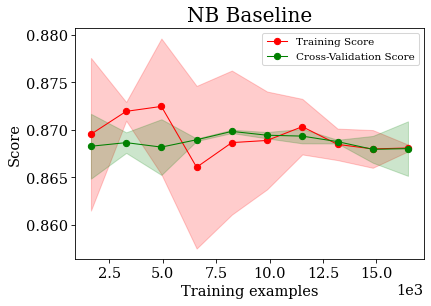

In [41]:
figura, score_txt, nb_train_stat, nb_val_stat = plot_learning_curve(
    nbModel, X_train, y_train, title='NB Baseline', cv=2, scorer='roc_auc'
)

#### Teste de Significância

Verificar se a metrica AUC do teste é uma estatística com probabilidade de vir do modelo treinado

In [42]:
nb_val_stat

[0.868529424317315, 0.0013867042540246038, 2]

In [43]:
p_val = t_test_S(
    x0 = nb_rocauc,
    x_hat = nb_val_stat[0],
    S = nb_val_stat[1],
    n = nb_val_stat[2]
)

Probabilidade da metrica calculada para base de teste pertencer à validação de treino:
P-Valor = 0.1297 (-2.317)
O valor 0.8708 tem probabilidade de 12.97% de pertencer a validação por flutuação estatística, e com IC=0.5, rejeito H0


In [44]:
# break

___
## Logistic Regression Model with full dataset

Para a Construção do modelo de baseline, o modelo é treinado com a amostra original (1:10) 

In [45]:
modelo = 'lr_model_full_data'

#### Model Training

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

scoring = {
    'AUC_ROC': 'roc_auc',
    'Accuracy': make_scorer(accuracy_score),
    'AUC_PR': make_scorer(average_precision_score)
}

param_grid = {
    'max_iter': [250, 500],
    'tol': [0.001],
    'random_state': [seed],
    'C': [1.2 , 1., .5, .25, .2, 0.1, .05],
    'class_weight': [None], #, Balanced]
    'l1_ratio': [.02, .05, .1, .25, .5, .75, .95],
    'solver': ['saga'],
    'penalty': ['elasticnet'],
}

lrcv = GridSearchCV(
    LogisticRegression(),
    param_grid=param_grid,
    scoring=scoring,
    refit='AUC_ROC',
    cv=2,
    n_jobs=4,
    return_train_score=True
    )


In [47]:
## Contando o numero de permutações pela grade de parametros
from sklearn.model_selection import ParameterGrid

pg = ParameterGrid(param_grid)

print(f'Numero de Permutação dos hiperparametros: {len(pg):.0f}')

Numero de Permutação dos hiperparametros: 98


In [48]:
lrcv.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': [1.2, 1.0, 0.5, 0.25, 0.2, 0.1, 0.05],
                         'class_weight': [None],
                         'l1_ratio': [0.02, 0.05, 0.1, 0.25, 0.5, 0.75, 0.95],
                         'max_iter': [250, 500], 'penalty': ['elasticnet'],
                         'random_state': [123], 'solver': ['saga'],
                         'tol': [0.001]},
             refit='AUC_ROC', return_train_score=True,
             scoring={'AUC_PR': make_scorer(average_precision_score, response_method='predict'),
                      'AUC_ROC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score, response_method='predict')})

In [49]:
dict_str = str(lrcv.best_params_)

print(dict_str)

{'C': 1.2, 'class_weight': None, 'l1_ratio': 0.02, 'max_iter': 500, 'penalty': 'elasticnet', 'random_state': 123, 'solver': 'saga', 'tol': 0.001}


In [50]:
lrModel = LogisticRegression(**lrcv.best_params_, n_jobs=4)

lrModel.fit(X_train, y_train)

LogisticRegression(C=1.2, l1_ratio=0.02, max_iter=500, n_jobs=4,
                   penalty='elasticnet', random_state=123, solver='saga',
                   tol=0.001)

In [51]:
dict_str = str(lrModel.get_params(deep=True))

print(dict_str)

{'C': 1.2, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.02, 'max_iter': 500, 'multi_class': 'auto', 'n_jobs': 4, 'penalty': 'elasticnet', 'random_state': 123, 'solver': 'saga', 'tol': 0.001, 'verbose': 0, 'warm_start': False}


#### Feature Evaluation

In [52]:
w = lrModel.coef_
w0 = lrModel.intercept_

print(f'Coeficientes:\n{w[0]}')
print(f'Intercptos:\n{w0}')

Coeficientes:
[ 0.0119  0.0039 -0.0149 -0.0026  0.0044 -0.0577  0.0426  0.0068 -0.062
 -0.001 ]
Intercptos:
[0.0006]


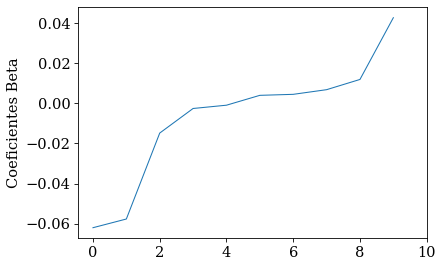

In [53]:
beta = np.sort(w[0])

plt.plot(beta, linewidth=1)
plt.ylabel('Coeficientes Beta')
plt.xticks(np.arange(0, len(beta)+1,2))
plt.show();

In [54]:
# https://christophm.github.io/interpretable-ml-book/logistic.html
# https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/

import math

## Coleta o nome das features 
lr_feature_importance = pd.DataFrame(feature_names, columns=['feature']) 
## calcula o peso de w_n quando x_n <= x_n+1
lr_feature_importance['LR Importance'] = pow(math.e, np.abs(w[0])) - 1 ## abs -> importancia independente da classe
## Adicionando os betas para analise de sinal: negativos == 0, positivos == 1
lr_feature_importance['Betas'] = np.round(w[0], decimals=5)
lr_feature_importance = lr_feature_importance.sort_values(by=['LR Importance'], ascending=False)
## Reset no valor do index para rankear
lr_feature_importance.reset_index(inplace=True, drop=True)
## Construindo Ranking e adicionando para não iniciar por zero
lr_feature_importance['LR Rank'] = lr_feature_importance.index+1


In [55]:
lr_feature_importance

,feature,LR Importance,Betas,LR Rank
0,euribor3m,0.0640,-0.0620,1
1,emp.var.rate,0.0594,-0.0577,2
2,cons.price.idx,0.0435,0.0426,3
3,campaign,0.0150,-0.0149,4
4,age,0.0119,0.0119,5
5,cons.conf.idx,0.0068,0.0068,6
6,previous,0.0045,0.0044,7
7,duration,0.0040,0.0039,8
8,pdays,0.0026,-0.0026,9
9,nr.employed,0.0010,-0.0010,10


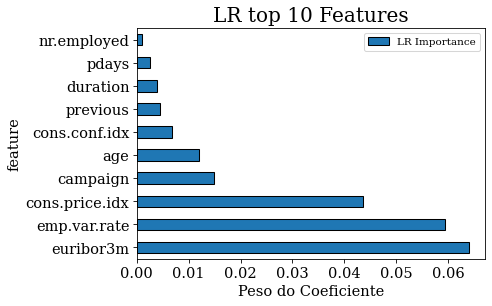

In [56]:
lr_feature_importance.iloc[0:10].plot.barh(x='feature', y='LR Importance', edgecolor='k')
plt.title('LR top 10 Features')
plt.xlabel('Peso do Coeficiente')
plt.show();

In [57]:
## Associando Feature Importance com IV
dflr_feature_importance = pd.merge(lr_feature_importance, iv, how='inner',
                                   left_on='feature', right_on='Variable').drop('Variable', axis=1)

dflr_feature_importance.head(7)

,feature,LR Importance,Betas,LR Rank,IV,Predictive Power
0,euribor3m,0.0640,-0.0620,1,1.0460,suspicious
1,emp.var.rate,0.0594,-0.0577,2,1.0698,suspicious
2,cons.price.idx,0.0435,0.0426,3,0.4402,strong
3,campaign,0.0150,-0.0149,4,0.0542,weak
4,age,0.0119,0.0119,5,0.1394,medium
5,cons.conf.idx,0.0068,0.0068,6,0.8607,suspicious
6,previous,0.0045,0.0044,7,0.3505,strong


### Model Evaluation

In [58]:
lr_yhat, lr_yprob, lr_rocauc, lr_aucpr = model_eval(lrModel, X_test, y_test)

Accuracia: 90.76%
AUC-ROC Score médio: 0.9019
AUC-PR Score médio: 0.5374


#### Curva ROC

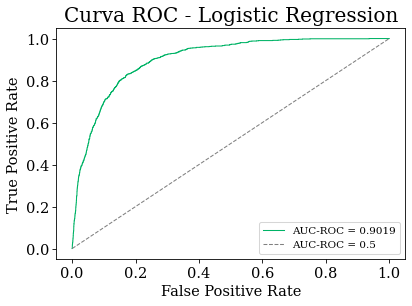

In [59]:
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, lr_yprob[:,1])
figura = plot_curva_roc(lr_fpr, lr_tpr, lr_rocauc, 'Logistic Regression')

#### Curva Precision-Recall

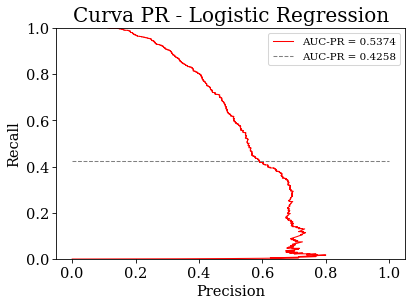

In [60]:
lr_precision, lr_recall, lr_thresholds_pr = precision_recall_curve(y_test, lr_yprob[:,1])
figura = plot_curva_pr(lr_precision, lr_recall, lr_aucpr, 'Logistic Regression')

#### Komogorov-Smirnov

In [61]:
df_clf = pd.DataFrame({'target': y_test, 'lr_yprob':lr_yprob[:,1]})


lr_stat_ks, lr_ks_val = ks(df_clf)

KS: 0.6556
p-valor: 0.0000


#### Separação de Classes

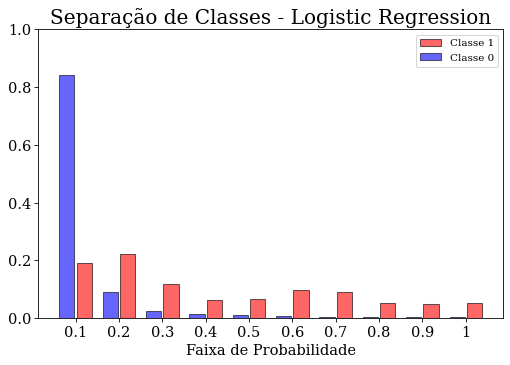

In [62]:
figura, classe0, classe1 = plot_separacao_classes(dataset=df_clf,
                                                 colunas=['lr_yprob'],
                                                 titulos=['Logistic Regression'],
                                                 modelo=modelo)

In [63]:
df_metrics = pracc_metrics(y_test, lr_yprob)

df_metrics['Class 0'] = classe0[0]
df_metrics['Class 1'] = classe1[0]
df_metrics['Class 0 Ratio'] = np.round( df_metrics['Class 0'] / (df_metrics['Class 1'] + df_metrics['Class 0']), 4)
df_metrics['Class 1 Ratio'] = np.round( df_metrics['Class 1'] / (df_metrics['Class 1'] + df_metrics['Class 0']), 4)

df_metrics

,percentil,tp,tn,fp,fn,precision,recall,accuracy,Class 0,Class 1,Class 0 Ratio,Class 1 Ratio
0,0.1000,751,6144,1166,177,0.6819,0.8249,0.8370,0.8405,0.1907,0.8150,0.1850
1,0.2000,544,6808,502,384,0.7333,0.7588,0.8924,0.0908,0.2231,0.2894,0.7106
2,0.3000,434,6975,335,494,0.7491,0.7109,0.8994,0.0228,0.1185,0.1616,0.8384
3,0.4000,377,7076,234,551,0.7724,0.6871,0.9047,0.0138,0.0614,0.1836,0.8164
4,0.5000,316,7161,149,612,0.8004,0.6601,0.9076,0.0116,0.0657,0.1503,0.8497
5,0.6000,227,7209,101,701,0.8017,0.6154,0.9026,0.0066,0.0959,0.0641,0.9359
6,0.7000,142,7248,62,786,0.7991,0.5723,0.8971,0.0053,0.0916,0.0550,0.9450
7,0.8000,93,7273,37,835,0.8062,0.5476,0.8941,0.0034,0.0528,0.0608,0.9392
8,0.9000,47,7288,22,881,0.7867,0.5238,0.8904,0.0021,0.0496,0.0398,0.9602
9,1.0000,0,7310,0,928,0.4437,0.5000,0.8874,0.0030,0.0506,0.0561,0.9439


#### Learning Curve

roc_auc: Score
Train Score: 0.890 (0.003)Test Score: 0.889 (0.004)
--------------------


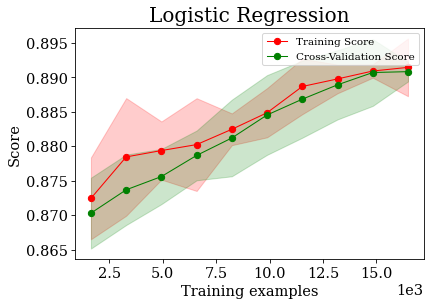

In [64]:
figura, score_txt, lr_train_stat, lr_val_stat = plot_learning_curve(
    lrModel, X_train, y_train, title='Logistic Regression', cv=2, scorer='roc_auc'
)

#### Teste de Significância

Verificar se a metrica AUC do teste é uma estatística com probabilidade de vir do modelo treinado

In [65]:
p_val = t_test_S(
    x0 = lr_rocauc,
    x_hat = lr_val_stat[0],
    S = lr_val_stat[1],
    n = lr_val_stat[2]
)

Probabilidade da metrica calculada para base de teste pertencer à validação de treino:
P-Valor = 0.0679 (-4.614)
O valor 0.9019 tem probabilidade de 6.79% de pertencer a validação por flutuação estatística, e com IC=0.5, rejeito H0


### Comparativo LR (full dataset) com Naive Bayes (Baseline)

In [66]:
print(f'Naive Bayes (Baseline) Model')
nb_scores = cross_validate(nbModel, X_train, y_train, cv=2,
                           scoring=('roc_auc', 'accuracy'),
                           return_train_score=False)

Naive Bayes (Baseline) Model


In [67]:
print(f'Logistic Regression Model (full dataset - unbalanced)')
lr_scores = cross_validate(lrModel, X_train, y_train, cv=2,
                           scoring=('roc_auc', 'accuracy'),
                           return_train_score=False)

Logistic Regression Model (full dataset - unbalanced)


Diferença entre as médias: 0.8680-0.8680=-0.0228
Os modelos parecem produzir resultados diferentes com IC=0.5 (rejeito H0)


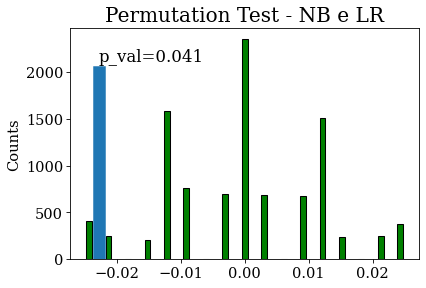

In [68]:
p_val, data, mean_diff = permutation_test(nb_scores['test_roc_auc'],
                                          lr_scores['test_roc_auc'])

plot_pts(data, p_val, mean_diff, title='NB e LR');

#### Deriva dos Dados: PSI (population stability index)

###### PSI < 0.1           => Sem mudanças, pode continuar usando o modelo  
###### PSI >= 0.1 < 0.2    => Mudanças pequenas podem ser necessárias  
###### PSI >= 0.2          => Mudanças Significativas são necessárias, não se deve usar esse modelo mais, retreino é necessário   


In [69]:
## calcula as probabilidades da base de treino 
y_prob_train = lrModel.predict_proba(X_train)

psi_fixo = psi(y_prob_train[:,1], lr_yprob[:,1], modo='fixo')
psi_quantil = psi(y_prob_train[:,1], lr_yprob[:,1], modo='quantil')

print(f'Valores PSI')
print(f'PSI - Valores de Bin fixo {np.mean(psi_fixo):.4f}')
print(f'PSI - Valores de Bin quantil {np.mean(psi_quantil):.4f}')

Valores PSI
PSI - Valores de Bin fixo 0.1000
PSI - Valores de Bin quantil 0.1001


In [70]:
# break

___
## Logistic Regression Model with RUS

Para a Construção do modelo de baseline, o modelo é treinado com a amostra original (1:10) 

In [71]:
modelo = 'lr_rus_model'

#### Model Training

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

scoring = {
    'AUC_ROC': 'roc_auc',
    'Accuracy': make_scorer(accuracy_score),
    'AUC_PR': make_scorer(average_precision_score)
}

param_grid = {
    'max_iter': [250, 500],
    'tol': [0.001],
    'random_state': [seed],
    'C': [1.2 , 1., .5, .25, .2, 0.1, .05],
    'class_weight': [None], #, Balanced]
    'l1_ratio': [.02, .05, .1, .25, .5, .75, .95],
    'solver': ['saga'],
    'penalty': ['elasticnet'],
}

lrcv = GridSearchCV(
    LogisticRegression(),
    param_grid=param_grid,
    scoring=scoring,
    refit='AUC_ROC',
    cv=2,
    n_jobs=4,
    return_train_score=True
    )


In [73]:
## Contando o numero de permutações pela grade de parametros
from sklearn.model_selection import ParameterGrid

pg = ParameterGrid(param_grid)

print(f'Numero de Permutação dos hiperparametros: {len(pg):.0f}')

Numero de Permutação dos hiperparametros: 98


In [74]:
lrcv.fit(X_train_RUS, y_train_RUS)

GridSearchCV(cv=2, estimator=LogisticRegression(), n_jobs=4,
             param_grid={'C': [1.2, 1.0, 0.5, 0.25, 0.2, 0.1, 0.05],
                         'class_weight': [None],
                         'l1_ratio': [0.02, 0.05, 0.1, 0.25, 0.5, 0.75, 0.95],
                         'max_iter': [250, 500], 'penalty': ['elasticnet'],
                         'random_state': [123], 'solver': ['saga'],
                         'tol': [0.001]},
             refit='AUC_ROC', return_train_score=True,
             scoring={'AUC_PR': make_scorer(average_precision_score, response_method='predict'),
                      'AUC_ROC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score, response_method='predict')})

In [75]:
dict_str = str(lrcv.best_params_)

print(dict_str)

{'C': 1.0, 'class_weight': None, 'l1_ratio': 0.02, 'max_iter': 500, 'penalty': 'elasticnet', 'random_state': 123, 'solver': 'saga', 'tol': 0.001}


In [76]:
lrRusModel = LogisticRegression(**lrcv.best_params_, n_jobs=4)

lrRusModel.fit(X_train_RUS, y_train_RUS)

LogisticRegression(l1_ratio=0.02, max_iter=500, n_jobs=4, penalty='elasticnet',
                   random_state=123, solver='saga', tol=0.001)

In [77]:
dict_str = str(lrRusModel.get_params(deep=True))

print(dict_str)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 0.02, 'max_iter': 500, 'multi_class': 'auto', 'n_jobs': 4, 'penalty': 'elasticnet', 'random_state': 123, 'solver': 'saga', 'tol': 0.001, 'verbose': 0, 'warm_start': False}


#### Feature Evaluation

In [78]:
w = lrRusModel.coef_
w0 = lrRusModel.intercept_

print(f'Coeficientes:\n{w[0]}')
print(f'Intercptos:\n{w0}')

Coeficientes:
[ 0.0127  0.0049 -0.0118 -0.0028  0.0036 -0.0455  0.0307  0.0033 -0.0476
 -0.0004]
Intercptos:
[0.0004]


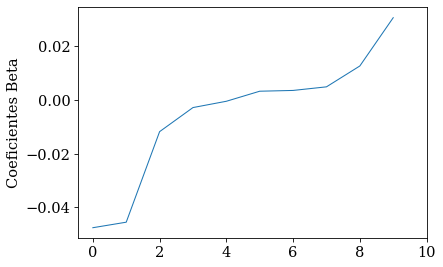

In [79]:
beta = np.sort(w[0])

plt.plot(beta, linewidth=1)
plt.ylabel('Coeficientes Beta')
plt.xticks(np.arange(0, len(beta)+1,2))
plt.show();

In [80]:
# https://christophm.github.io/interpretable-ml-book/logistic.html
# https://sefiks.com/2021/01/06/feature-importance-in-logistic-regression/

import math

## Coleta o nome das features 
lr_rus_feature_importance = pd.DataFrame(feature_names, columns=['feature']) 
## calcula o peso de w_n quando x_n <= x_n+1
lr_rus_feature_importance['LR Importance'] = pow(math.e, np.abs(w[0])) - 1 ## abs -> importancia independente da classe
## Adicionando os betas para analise de sinal: negativos == 0, positivos == 1
lr_rus_feature_importance['Betas'] = np.round(w[0], decimals=5)
lr_rus_feature_importance = lr_rus_feature_importance.sort_values(by=['LR Importance'], ascending=False)
## Reset no valor do index para rankear
lr_rus_feature_importance.reset_index(inplace=True, drop=True)
## Construindo Ranking e adicionando para não iniciar por zero
lr_rus_feature_importance['LR Rank'] = lr_rus_feature_importance.index+1


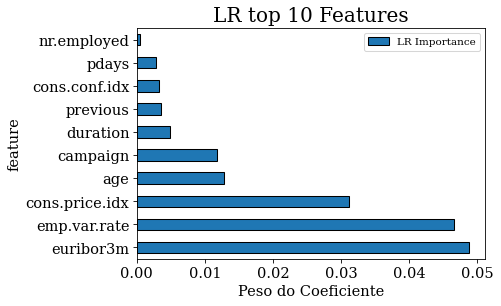

In [81]:
lr_rus_feature_importance.iloc[0:10].plot.barh(x='feature', y='LR Importance', edgecolor='k')
plt.title('LR top 10 Features')
plt.xlabel('Peso do Coeficiente')
plt.show();

In [82]:
## Associando Feature Importance com IV
dflr_rus_feature_importance = pd.merge(lr_rus_feature_importance, iv, how='inner',
                                   left_on='feature', right_on='Variable').drop('Variable', axis=1)

dflr_rus_feature_importance.head(7)

,feature,LR Importance,Betas,LR Rank,IV,Predictive Power
0,euribor3m,0.0487,-0.0476,1,1.0460,suspicious
1,emp.var.rate,0.0466,-0.0455,2,1.0698,suspicious
2,cons.price.idx,0.0312,0.0307,3,0.4402,strong
3,age,0.0128,0.0127,4,0.1394,medium
4,campaign,0.0118,-0.0118,5,0.0542,weak
5,duration,0.0049,0.0049,6,1.9618,suspicious
6,previous,0.0036,0.0036,7,0.3505,strong


### Model Evaluation

In [83]:
lr_rus_yhat, lr_rus_yprob, lr_rus_rocauc, lr_rus_aucpr = model_eval(lrRusModel, X_test, y_test)

df_clf['lr_rus_yprob'] = lr_rus_yprob[:,1]

Accuracia: 85.19%
AUC-ROC Score médio: 0.8884
AUC-PR Score médio: 0.5150


#### Curva ROC

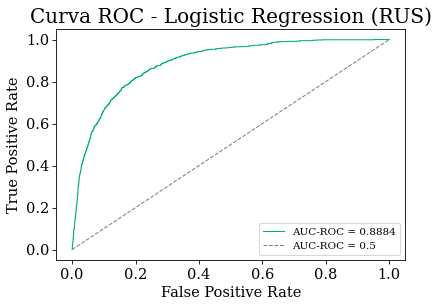

In [84]:
lr_rus_fpr, lr_rus_tpr, lr_rus_thresholds = roc_curve(y_test, lr_rus_yprob[:,1])
figura = plot_curva_roc(lr_rus_fpr, lr_rus_tpr, lr_rus_rocauc, 'Logistic Regression (RUS)')

#### Curva Precision-Recall

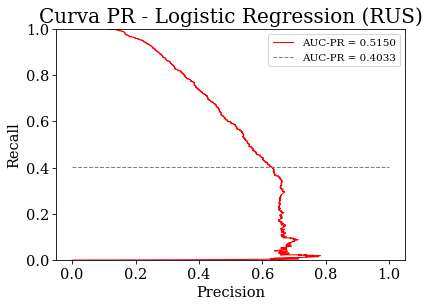

In [85]:
lr_rus_precision, lr_rus_recall, lr_rus_thresholds_pr = precision_recall_curve(y_test, lr_rus_yprob[:,1])
figura = plot_curva_pr(lr_rus_precision, lr_rus_recall, lr_rus_aucpr, 'Logistic Regression (RUS)')

#### Correção de Probabilidade

In [86]:
beta = y_train_RUS[y_train_RUS==0].shape[0]/y_train[y_train==0].shape[0]
print(f'lambda = N1/N0 = {beta}')
# N0 - numero de elementos da classe majoritaria
# N1 - numero de elementos de downsampling classe majoritaria

lrRUS_yprob_corr = beta*df_clf['lr_yprob'] / (df_clf['lr_yprob'] * beta - df_clf['lr_yprob']+1)
df_clf['lr_rus_yprob_corr'] = lrRUS_yprob_corr

lambda = N1/N0 = 0.12695806826732334


#### Komogorov-Smirnov

In [87]:
df_clf_rus = pd.DataFrame({'target': y_test, 'lr_rus_yprob_corr':lr_yprob[:,1]})


lr_stat_ks, lr_ks_val = ks(df_clf_rus)

KS: 0.6556
p-valor: 0.0000


In [88]:
kstable(df_clf, target='target', prob='lr_rus_yprob_corr')

,min_prob,max_prob,events,nonevents,event_rate,nonevent_rate,cum_event_rate,cum_nonevent_rate,KS
0,0.0461,0.9995,458,366,49.35%,5.01%,0.4935,0.0501,44.3000
1,0.0166,0.0461,241,583,25.97%,7.98%,0.7532,0.1298,62.3000
2,0.0108,0.0166,111,713,11.96%,9.75%,0.8728,0.2274,64.5000
3,0.0082,0.0108,57,766,6.14%,10.48%,0.9343,0.3321,60.2000
4,0.0066,0.0082,27,797,2.91%,10.90%,0.9634,0.4412,52.2000
5,0.0056,0.0066,17,807,1.83%,11.04%,0.9817,0.5516,43.0000
6,0.0048,0.0056,11,812,1.19%,11.11%,0.9935,0.6627,33.1000
7,0.0041,0.0048,5,819,0.54%,11.20%,0.9989,0.7747,22.4000
8,0.0035,0.0041,0,824,0.00%,11.27%,0.9989,0.8874,11.2000
9,0.0015,0.0035,1,823,0.11%,11.26%,1.0000,1.0000,-0.0000


#### Separação de Classes

In [89]:
df_clf

,target,lr_yprob,lr_rus_yprob,lr_rus_yprob_corr,target0,bucket
848,0,0.0749,0.3699,0.0102,1,"(0.00819, 0.0108]"
5007,1,0.4359,0.9093,0.0893,0,"(0.0461, 1.0]"
23842,0,0.0477,0.2504,0.0063,1,"(0.00555, 0.00656]"
40620,0,0.0844,0.3149,0.0116,1,"(0.0108, 0.0166]"
7595,0,0.0552,0.2786,0.0074,1,"(0.00656, 0.00819]"
...,...,...,...,...,...,...
14360,0,0.2709,0.8068,0.0450,1,"(0.0166, 0.0461]"
38622,0,0.0672,0.2583,0.0091,1,"(0.00819, 0.0108]"
36533,0,0.4129,0.8168,0.0820,1,"(0.0461, 1.0]"
37777,0,0.1615,0.5502,0.0239,1,"(0.0166, 0.0461]"


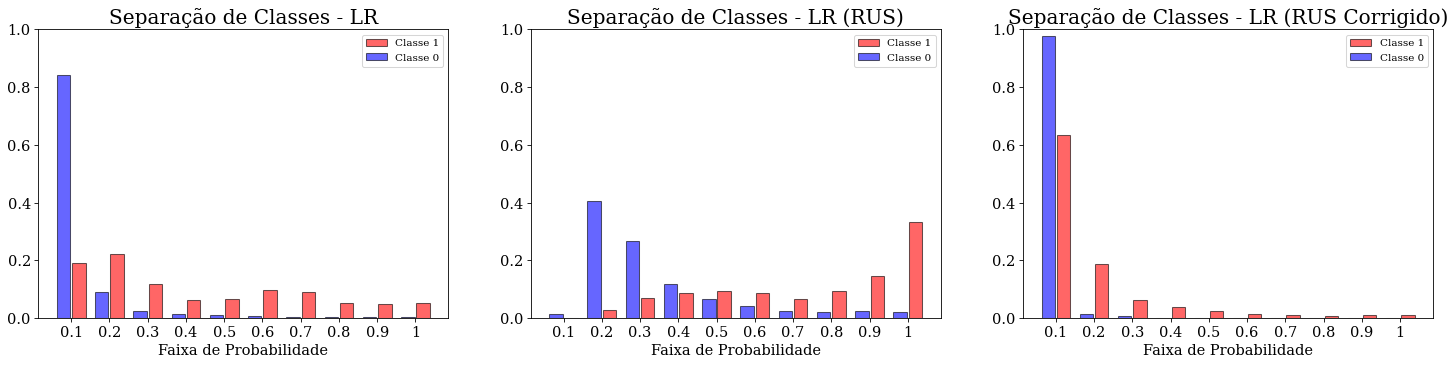

In [91]:
figura, classe0, classe1 = plot_separacao_classes(dataset=df_clf,
                                                 colunas=['lr_yprob', 'lr_rus_yprob', 'lr_rus_yprob_corr'],
                                                 titulos=['LR', 'LR (RUS)',  'LR (RUS Corrigido)'],
                                                 modelo=modelo)

In [92]:
df_metrics = pracc_metrics(y_test, lr_rus_yprob)

df_metrics['Class 0'] = classe0[0]
df_metrics['Class 1'] = classe1[0]
df_metrics['Class 0 Ratio'] = np.round( df_metrics['Class 0'] / (df_metrics['Class 1'] + df_metrics['Class 0']), 4)
df_metrics['Class 1 Ratio'] = np.round( df_metrics['Class 1'] / (df_metrics['Class 1'] + df_metrics['Class 0']), 4)

df_metrics

,percentil,tp,tn,fp,fn,precision,recall,accuracy,Class 0,Class 1,Class 0 Ratio,Class 1 Ratio
0,0.1000,928,91,7219,0,0.5570,0.5062,0.1237,0.8405,0.1907,0.8150,0.1850
1,0.2000,903,3054,4256,25,0.5835,0.6954,0.4803,0.0908,0.2231,0.2894,0.7106
2,0.3000,839,5005,2305,89,0.6247,0.7944,0.7094,0.0228,0.1185,0.1616,0.8384
3,0.4000,757,5863,1447,171,0.6576,0.8089,0.8036,0.0138,0.0614,0.1836,0.8164
4,0.5000,671,6347,963,257,0.6859,0.7957,0.8519,0.0116,0.0657,0.1503,0.8497
5,0.6000,592,6645,665,336,0.7114,0.7735,0.8785,0.0066,0.0959,0.0641,0.9359
6,0.7000,531,6818,492,397,0.7320,0.7524,0.8921,0.0053,0.0916,0.0550,0.9450
7,0.8000,445,6974,336,483,0.7525,0.7168,0.9006,0.0034,0.0528,0.0608,0.9392
8,0.9000,310,7151,159,618,0.7907,0.6562,0.9057,0.0021,0.0496,0.0398,0.9602
9,1.0000,0,7310,0,928,0.4437,0.5000,0.8874,0.0030,0.0506,0.0561,0.9439


#### Learning Curve

roc_auc: Score
Train Score: 0.874 (0.006)Test Score: 0.873 (0.010)
--------------------


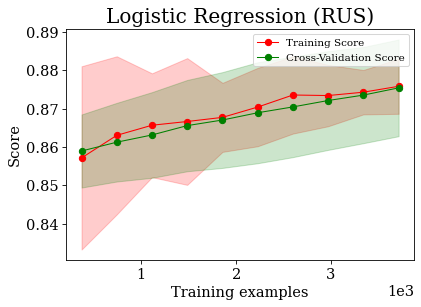

In [93]:
figura, score_txt, lr_rus_train_stat, lr_rus_val_stat = plot_learning_curve(
    lrRusModel, X_train_RUS, y_train_RUS, title='Logistic Regression (RUS)', cv=2, scorer='roc_auc'
)

#### Teste de Significância

Verificar se a metrica AUC do teste é uma estatística com probabilidade de vir do modelo treinado

In [94]:
lr_rus_val_stat

[0.8729105437978412, 0.009865248222993233, 2]

In [95]:
p_val = t_test_S(
    x0 = lr_rus_rocauc,
    x_hat = lr_rus_val_stat[0],
    S = lr_rus_val_stat[1],
    n = lr_rus_val_stat[2]
)

Probabilidade da metrica calculada para base de teste pertencer à validação de treino:
P-Valor = 0.1348 (-2.219)
O valor 0.8884 tem probabilidade de 13.48% de pertencer a validação por flutuação estatística, e com IC=0.5, rejeito H0


In [ ]:
break